<a href="https://colab.research.google.com/github/pushpakolli/FMML_lab_modules/blob/main/Copy_of_FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [ ]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [ ]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-12 15:15:00--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.138.94.32, 108.138.94.65, 108.138.94.113, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.138.94.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   245MB/s    in 0.2s    

2024-05-12 15:15:00 (245 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


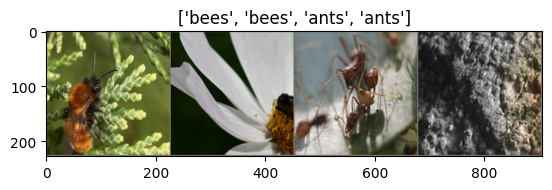

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.9MB/s]


In [ ]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6176 Acc: 0.6926

Epoch 1/4
----------
Loss: 0.5274 Acc: 0.7459

Epoch 2/4
----------
Loss: 0.6346 Acc: 0.7336

Epoch 3/4
----------
Loss: 0.4598 Acc: 0.8033

Epoch 4/4
----------
Loss: 0.3951 Acc: 0.8525



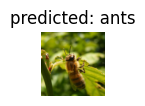

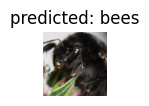

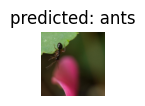

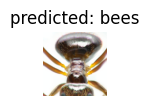

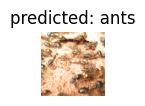

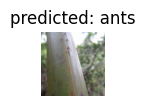

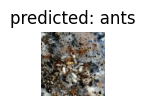

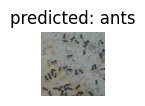

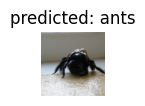

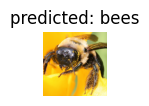

In [ ]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


#ANSWER-1

Data augmentation techniques such as resizing, cropping, flipping, rotating, and adjusting brightness or contrast are commonly used in training machine learning models, particularly in computer vision tasks. These techniques serve several important purposes:

**Increase Training Data Variability:** By applying various transformations to the original images, you can create multiple versions of each image. This effectively increases the size of your training dataset without collecting new data, which is particularly useful when you have a limited amount of labeled data.

**Regularization:** Data augmentation acts as a form of regularization, helping to prevent overfitting. By exposing the model to slightly modified versions of the training data, it learns to generalize better to new, unseen data.

**Robustness to Variations:** Real-world data often exhibits variations in lighting, orientation, scale, and other factors. Data augmentation helps the model become robust to these variations by training it on a diverse set of examples.

**Improved Generalization:** With a more diverse training dataset, the model learns to focus on the essential features of the objects it's meant to recognize, rather than being overly sensitive to specific variations present in the training data.

**Reduced Memorization:** When a model memorizes specific training examples rather than learning generalizable patterns, it tends to perform poorly on new data. Data augmentation discourages memorization by presenting the model with a wide range of variations on each example.

**Invariance Learning:** Certain data augmentations, such as rotation and flipping, can help the model learn to recognize objects regardless of their orientation or spatial location in the image.

In summary, data augmentation is a crucial technique in machine learning, helping models to generalize better, become more robust, and learn useful features from the training data.

#ANSWER-2

If you train a ResNet model from scratch without using pretraining, it typically requires a significantly larger dataset and more computational resources compared to using pretrained weights. The performance of the model trained from scratch may be inferior in terms of both convergence speed and final accuracy, especially when dealing with limited data.

Without pretrained weights, the model starts with random initialization of its parameters, and it needs to learn all the features from scratch during the training process. This often leads to longer training times and a higher risk of overfitting, especially when the dataset is small.

Additionally, pretrained models trained on large datasets (such as ImageNet) have already learned rich feature representations that can be beneficial for a wide range of computer vision tasks. By leveraging these pretrained weights, you can often achieve better performance with less data and computational resources.

However, if you have a specific dataset that is vastly different from the data the pretrained model was trained on, training from scratch might be necessary to adapt the model to the new domain. In such cases, the performance of the model trained from scratch would depend on the complexity of the task, the size and quality of the training dataset, and the model architecture chosen.

#ANSWER-3

The effectiveness of using a pretrained model on a different dataset depends on several factors:

**Domain Similarity:** If the dataset the model was pretrained on is significantly different from the new dataset (such as the ants vs. bees dataset), the pretrained model may not capture relevant features for the new task as effectively. For example, if the pretrained model was trained on natural images like landscapes or animals, it may still have learned generalizable features like edges, textures, and object shapes, which could be somewhat useful. However, if the new dataset has very different characteristics (e.g., medical images or satellite imagery), the features learned by the pretrained model might not transfer well.

**Task Similarity:** The performance of the pretrained model also depends on the similarity between the tasks. If the new task (e.g., classifying ants vs. bees) is similar to the original task the model was pretrained on (e.g., object recognition in natural images), there's a higher chance that the pretrained model will be useful. However, if the tasks are vastly different (e.g., image captioning or semantic segmentation), the features learned by the pretrained model may not be as relevant.

**Amount of Transfer Learning:** Even if the pretrained model is not perfectly aligned with the new dataset and task, transfer learning can still provide benefits. By fine-tuning the pretrained model on the new dataset, you allow the model to adapt its learned representations to better suit the new task. The amount of transfer learning required depends on factors such as the size of the new dataset and the similarity of the tasks.

In summary, while using a pretrained model on a significantly different dataset may not yield optimal performance out-of-the-box, it can still provide a useful starting point. Fine-tuning the pretrained model on the new dataset and task is often necessary to achieve the best performance.